## MobilityDB : A Moving Object Database System for Spatio-Temporal Data

### (Optional) Creating a dedicated conda environment
```bash
conda create -n mobilityDB python=3.11
conda activate mobilityDB
```

### Requirements

- PostgreSQL (>= 14)
    - Windows :
        ```bash
        choco install postgresql15
        ```
    - Linux :
        ```bash
        sudo apt install postgresql-15
        ```
    - Mac :
        ```bash
        brew install libpq
        ```

- Docker : [https://docs.docker.com/get-docker/](https://docs.docker.com/get-docker/)
- psycopg2-binary, python-mobilitydb, pandas
    ```bash
    pip install psycopg2
    pip install python-mobilitydb
    pip install pandas
    ```

### Import necessary packages

In [ ]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import psycopg2
from mobilitydb.psycopg import register

from tqdm import tqdm

## Concrete example : TEC (bus lines in Province de Liège)

### Getting the TEC data from the official website (keep it as zip)

In [ ]:
compute = False

In [ ]:
if compute:
    os.system("rm -rf TEC-GTFS.zip")
    os.system("wget https://opendata.tec-wl.be/Current%20GTFS/TEC-GTFS.zip --quiet")

### Load the data into the database

In [ ]:
if compute:
    os.system("rm -rf data")
    os.system("mkdir data")
    os.system("unzip -o TEC-GTFS.zip -d data")

### Isolate the Data for Province de Liège

In [ ]:
# Calendar : we want to keep only the services of Province de Liege and transform the calendar to have one row per week

if compute:
    # Remove calendar with service_id not starting by 'L'
    calendar = pd.read_csv('data/calendar.txt')
    calendar = calendar[calendar['service_id'].str.startswith('L')]

    new_calendar = pd.DataFrame(columns=['service_id', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'])

    for index, row in calendar.iterrows():
        start_date = row['start_date']
        end_date = row['end_date']
        service_id = row['service_id']

        start_date = pd.to_datetime(start_date, format='%Y%m%d')
        end_date = pd.to_datetime(end_date, format='%Y%m%d')
        
        start_monday = start_date - pd.to_timedelta(start_date.dayofweek, unit='d')
        end_sunday = end_date + pd.to_timedelta(6 - end_date.dayofweek, unit='d')

        nb_weeks = (end_sunday - start_monday).days // 7 + 1

        # create a new row for each week
        for i in range(nb_weeks):
            new_row = {
                'service_id': f'{service_id}_{i}',
                'monday': None,
                'tuesday': None,
                'wednesday': None,
                'thursday': None,
                'friday': None,
                'saturday': None,
                'sunday': None
            }

            # looking into the original row, set the days that are active
            for day in range(7):
                if row[calendar.columns[day+1]] == 1:
                    new_row[calendar.columns[day+1]] = start_monday + pd.to_timedelta(i*7 + day, unit='d')

            new_calendar.loc[len(new_calendar)] = new_row

    new_calendar.to_csv('data/calendar.txt', index=False)

In [ ]:
# Agency : we want to keep only the agency of Province de Liege

if compute:
    agency = pd.read_csv('data/agency.txt')
    agency = agency[agency['agency_id'] == 'L']
    agency.to_csv('data/agency.txt', index=False)

In [ ]:

# Remove the table calendar_dates (too specific)

if compute:
    os.system("rm -rf data/calendar_dates.txt")

In [ ]:

# Remove the table feed_info (not useful)

if compute:
    os.system("rm -rf data/feed_info.txt")

In [ ]:
# Routes : we want to keep only the routes of Province de Liege
if compute:
    routes = pd.read_csv('data/routes.txt')
    routes = routes[routes['agency_id'] == 'L']
    routes.to_csv('data/routes.txt', index=False)

In [ ]:
# Remove the table shapes (not useful)

if compute:
    os.system("rm -rf data/shapes.txt")

In [ ]:
# Trips : we want to keep only the trips of Province de Liege

if compute:
    # Remove trips with route_id not starting by 'L'
    trips = pd.read_csv('data/trips.txt')
    trips = trips[trips['route_id'].str.startswith('L')]

    # Remove column shape_id and block_id from trips
    trips = trips.drop(columns=['block_id','shape_id'])
    trips.to_csv('data/trips.txt', index=False)

In [ ]:
# Stops : we want to keep only the stops of Province de Liege

if compute:
    stops = pd.read_csv('data/stops.txt')
    stops = stops[stops['stop_id'].str.startswith('L')]
    stops.to_csv('data/stops.txt', index=False)

In [ ]:
# Stop_times : we want to keep only the stop_times of Province de Liege

if compute:
    # Remove stop_times with stop_id not starting by 'L'
    stop_times = pd.read_csv('data/stop_times.txt')
    stop_times = stop_times[stop_times['stop_id'].str.startswith('L')]
    stop_times = stop_times[stop_times['trip_id'].str.contains('-L_')]

    # Remove rows when the arrival time and departure time is greater than '23:59:59'
    stop_times = stop_times[(stop_times['arrival_time'].str[:2].astype(int) < 24)]
    stop_times = stop_times[(stop_times['departure_time'].str[:2].astype(int) < 24)]

    # if two consecutive rows have the same arrival_time drop the second one
    stop_times = stop_times.drop_duplicates(subset=['trip_id', 'arrival_time'], keep='first')

    # Transform departure_time and arrival_time to datetime our format is HH:MM:SS
    stop_times['departure_time'] = pd.to_datetime(stop_times['departure_time'], format='%H:%M:%S')
    stop_times['arrival_time'] = pd.to_datetime(stop_times['arrival_time'], format='%H:%M:%S')

    stop_times.to_csv('data/stop_times.txt', index=False)

### Pulling the Docker image and running the container with the data (rerun, the container might be slow to start)
```bash
docker pull mobilitydb/mobilitydb
docker volume create mobilitydb_data
docker run --name "mobilitydb" -d -p 25432:5432 -v PATH_TO_DATA:/var/lib/postgresql mobilitydb/mobilitydb
```

### Connect to the database using psycopg2 and python-mobilitydb

In [ ]:
connection = None

try:
    connection = psycopg2.connect(host='localhost', database='mobilitydb', user='docker', password='docker', port='25432')
    connection.autocommit = True
    print("Connected to PostgreSQL")

    register(connection)
    print("MobilityDB extension enabled")

    cursor = connection.cursor()

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to MobilityDB", error)

### Load the data into the database

In [ ]:
# Loading our data in PostgreSQL

with open('sql/load.sql', 'r') as f:
    cursor.execute(f.read())

print("Data loaded")

In [ ]:
# Creating the calendar_trips to have a "full" calendar with dates

with open('sql/manipulation.sql', 'r') as f:
    cursor.execute(f.read())

print("Data manipulated")

In [103]:
# Checking that everything went well

query = "SELECT * FROM calendar LIMIT 10"
cursor.execute(query)

colnames = [desc[0] for desc in cursor.description]
print(colnames)

for row in cursor.fetchall():
    print(row)

query = "SELECT * FROM calendar_trips WHERE service_id = 'L_PA_2023-23_LG_N3-Sem-N-3-26-1001100_0' LIMIT 10"
cursor.execute(query)

colnames = [desc[0] for desc in cursor.description]
print("\n" + str(colnames))

for row in cursor.fetchall():
    print(row)

['service_id', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
('L_PA_2023-23_LG_DI-Dimanche-05_0', None, None, None, None, None, None, datetime.date(2023, 5, 14))
('L_PA_2023-23_LG_DI-Dimanche-05_1', None, None, None, None, None, None, datetime.date(2023, 5, 21))
('L_PA_2023-23_LG_DI-Dimanche-05_2', None, None, None, None, None, None, datetime.date(2023, 5, 28))
('L_PA_2023-23_LG_DI-Dimanche-05_3', None, None, None, None, None, None, datetime.date(2023, 6, 4))
('L_PA_2023-23_LG_DI-Dimanche-06_0', None, None, None, None, None, None, datetime.date(2023, 6, 4))
('L_PA_2023-23_LG_DI-Dimanche-06_1', None, None, None, None, None, None, datetime.date(2023, 6, 11))
('L_PA_2023-23_LG_DI-Dimanche-06_2', None, None, None, None, None, None, datetime.date(2023, 6, 18))
('L_PA_2023-23_LG_DI-Dimanche-06_3', None, None, None, None, None, None, datetime.date(2023, 6, 25))
('L_PA_2023-23_LG_DI-Dimanche-06_4', None, None, None, None, None, None, datetime.date(2023, 7, 2))
(

### Transform the data into a MobilityDB trajectory

In [ ]:
# Transforming our data into MobilityDB

with open('sql/mobility.sql', 'r') as f:
    cursor.execute(f.read())

print("Mobility functions loaded")

In [ ]:
# Checking that everything went well
# Be aware that all the trajectories take place on the 1st January 1900
# This is a trick used to avoid the computation of all the trajectories, around 24 hours of computation vs 1-2 minutes
# We will query the database in the correct way using the calendar, service_id and trip_id to obtain the trajectories on the correct date

query = "SELECT * FROM stop_times_traj LIMIT 10;"
cursor.execute(query)

for row in cursor.fetchall():
    print(row)

## Let's now use the MobilityDB functions

### Imagine you want to know what bus to take to go to the University of Liège at 8:00 from the train station (Liège-Guillemins) 

In [ ]:
# Creation of our day of interest
hour_of_interest = "8:00:00"
day_of_interest = pd.to_datetime("2023-06-02", format='%Y-%m-%d')
date_of_interest = day_of_interest.date()
dayname = day_of_interest.day_name()

# Isolate the service_id of the day of interest
query = f"SELECT DISTINCT service_id FROM calendar_trips WHERE {dayname} = '{date_of_interest}'"
cursor.execute(query)

services = cursor.fetchall()
services = [service[0] for service in services]

# We will then isolate the zones of interest
box_tolerance = 0.001
 
lon_polytech = 5.560434
lat_polytech = 50.584305

lat_min_polytech = lat_polytech - box_tolerance
lat_max_polytech = lat_polytech + box_tolerance
lon_min_polytech = lon_polytech - box_tolerance
lon_max_polytech = lon_polytech + box_tolerance

lon_guillemins = 5.567853
lat_guillemins = 50.62537

lat_min_guillemins = lat_guillemins - box_tolerance
lat_max_guillemins = lat_guillemins + box_tolerance
lon_min_guillemins = lon_guillemins - box_tolerance
lon_max_guillemins = lon_guillemins + box_tolerance

query = f'SELECT trip_id FROM stop_times_traj WHERE intersects(traj, ST_MakeEnvelope({lon_min_polytech}, {lat_min_polytech}, {lon_max_polytech}, {lat_max_polytech}, 4326)) AND intersects(traj, ST_MakeEnvelope({lon_min_guillemins}, {lat_min_guillemins}, {lon_max_guillemins}, {lat_max_guillemins}, 4326))'
cursor.execute(query)

trips = cursor.fetchall()
trips = [trip[0] for trip in trips]

if len(services) == 1:
    formated_services = f"('{services[0]}')"
else:
    formated_services = tuple(services)

# Isolate the trips that have the correct service_id
query = f"SELECT trip_id FROM calendar_trips WHERE service_id IN {formated_services}"
cursor.execute(query)

trips_correct_services = cursor.fetchall()
trips_correct_services = [trip[0][:-2] for trip in trips_correct_services]

print(f"Number of trips during the day of interest : {len(trips_correct_services)}")

trips = list(set(trips_correct_services).intersection(trips))

print(f"Number of trips connecting the two zones on the day of interest : {len(trips)}")

# Using those trips we can now isolate the stop_times of interest
query = f"SELECT * FROM stop_times WHERE trip_id IN {tuple(trips)} AND arrival_time <= '1900-01-01 {hour_of_interest}' AND stop_id LIKE 'Lstpoly%'"
cursor.execute(query)

final_trips = cursor.fetchall()
final_trips = [trip[0] for trip in final_trips]

# The stop_sequence was hardcoded to make sure the bus goes in the right direction
print("\nTimes of departure of the bus from Guillemins to get to Polytech at 8:00 :")
query = f"SELECT DISTINCT stop_name, departure_time, route_short_name FROM stop_times INNER JOIN stops ON stop_times.stop_id = stops.stop_id INNER JOIN trips ON stop_times.trip_id = trips.trip_id INNER JOIN routes ON trips.route_id = routes.route_id WHERE stop_times.trip_id IN {tuple(final_trips)} AND stop_times.stop_id LIKE 'LlgguilB%' AND departure_time <= '1900-01-01 {hour_of_interest}' AND stop_sequence < 10 ORDER BY departure_time ASC"
cursor.execute(query)

# Store in a pandas dataframe
colnames = [desc[0] for desc in cursor.description]
df = pd.DataFrame(columns=colnames)
for row in cursor.fetchall():
    index = len(df)
    df.loc[index] = (row[0], row[1].strftime("%H:%M:%S"), row[2])

df.head(20)

### Create a box of interest around the campus of ULiège

In [ ]:
# Identification of the routes that go through the area of interest

# Campus of ULiège in Sart-Tilman
LAT_MIN = 50.5820
LAT_MAX = 50.6022
LON_MIN = 5.5483
LON_MAX = 5.5869

query = f"SELECT DISTINCT route_short_name FROM stop_times_traj INNER JOIN trips ON stop_times_traj.trip_id = trips.trip_id INNER JOIN routes ON trips.route_id = routes.route_id WHERE intersects(traj, ST_MakeEnvelope({LON_MIN}, {LAT_MIN}, {LON_MAX}, {LAT_MAX}, 4326));"
cursor.execute(query)

print("Routes that go through the area of interest :")
for row in cursor.fetchall():
    print(row[0])

### Heatmap of the bus lines inside the Province of Liège

In [ ]:
# Getting the limiting coordinates of the area of interest

# lowest latitude
query = "SELECT MIN(stop_lat) FROM stop_times_coord;"
cursor.execute(query)

low_lat = None
for row in cursor.fetchall():
    low_lat = row[0]

# highest latitude
query = "SELECT MAX(stop_lat) FROM stop_times_coord;"
cursor.execute(query)

high_lat = None
for row in cursor.fetchall():
    high_lat = row[0]

# lowest longitude
query = "SELECT MIN(stop_lon) FROM stop_times_coord;"
cursor.execute(query)

low_lon = None
for row in cursor.fetchall():
    low_lon = row[0]

# highest longitude
query = "SELECT MAX(stop_lon) FROM stop_times_coord;"
cursor.execute(query)

high_lon = None
for row in cursor.fetchall():
    high_lon = row[0]

print(low_lat, high_lat, low_lon, high_lon)

In [ ]:
# Creation of different areas of interest

# Sart-Tilman
query = f"SELECT traj FROM stop_times_traj WHERE intersects(traj, ST_MakeEnvelope({LON_MIN}, {LAT_MIN}, {LON_MAX}, {LAT_MAX}, 4326));"
cursor.execute(query)

trajs_srt = []
for row in tqdm(cursor.fetchall()):
    trajs_srt.append(row[0])

# Saint-Lambert
LAT_MIN_SL = 50.6439
LAT_MAX_SL = 50.6462
LON_MIN_SL = 5.5720
LON_MAX_SL = 5.5760
query = f"SELECT traj FROM stop_times_traj WHERE intersects(traj, ST_MakeEnvelope({LON_MIN_SL}, {LAT_MIN_SL}, {LON_MAX_SL}, {LAT_MAX_SL}, 4326));"
cursor.execute(query)

trajs_stlamber = []
for row in tqdm(cursor.fetchall()):
    trajs_stlamber.append(row[0])

# Eupen
LAT_MIN_EU = 50.6133
LAT_MAX_EU = 50.6525
LON_MIN_EU = 6.0006
LON_MAX_EU = 6.0722
query = f"SELECT traj FROM stop_times_traj WHERE intersects(traj, ST_MakeEnvelope({LON_MIN_EU}, {LAT_MIN_EU}, {LON_MAX_EU}, {LAT_MAX_EU}, 4326));"
cursor.execute(query)

trajs_marche = []
for row in tqdm(cursor.fetchall()):
    trajs_marche.append(row[0])

In [ ]:
# Creating the heatmap for the different areas of interest

plt.figure(figsize=(10, 14))

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.xlim(low_lon, high_lon)
plt.ylim(low_lat, high_lat)

plt.imshow(plt.imread('figs/map.png'), extent=[low_lon, high_lon, low_lat, high_lat])

for i in tqdm(range(len(trajs_srt))):
    x = []
    y = []
    for j in range(trajs_srt[i].numInstants):
        x.append(trajs_srt[i].getValues[j].x)
        y.append(trajs_srt[i].getValues[j].y)
    plt.plot(x, y, color='orange', alpha=0.005)

for i in tqdm(range(len(trajs_stlamber))):
    x = []
    y = []
    for j in range(trajs_stlamber[i].numInstants):
        x.append(trajs_stlamber[i].getValues[j].x)
        y.append(trajs_stlamber[i].getValues[j].y)
    plt.plot(x, y, color='lime', alpha=0.005)

for i in tqdm(range(len(trajs_marche))):
    x = []
    y = []
    for j in range(trajs_marche[i].numInstants):
        x.append(trajs_marche[i].getValues[j].x)
        y.append(trajs_marche[i].getValues[j].y)
    plt.plot(x, y, color='aqua', alpha=0.005)


plt.plot([LON_MIN, LON_MIN, LON_MAX, LON_MAX, LON_MIN], [LAT_MIN, LAT_MAX, LAT_MAX, LAT_MIN, LAT_MIN], color='red', label='Sart-Tilman Campus')
plt.plot([LON_MIN_SL, LON_MIN_SL, LON_MAX_SL, LON_MAX_SL, LON_MIN_SL], [LAT_MIN_SL, LAT_MAX_SL, LAT_MAX_SL, LAT_MIN_SL, LAT_MIN_SL], color='black', label='Saint-Lambert and Leopold Station Area')
plt.plot([LON_MIN_EU, LON_MIN_EU, LON_MAX_EU, LON_MAX_EU, LON_MIN_EU], [LAT_MIN_EU, LAT_MAX_EU, LAT_MAX_EU, LAT_MIN_EU, LAT_MIN_EU], color='blue', label='Eupen Area')

plt.title('Heatmap of all the trajectories')

plt.legend()
plt.savefig('figs/heatmap.png')
plt.show()

### Plot the number of bus lines in circulation over time

In [60]:
# By isolating the the service_id of the day of interest, we can isolate the trip_id of the day of interest

day_of_interest = pd.to_datetime("2023-06-02", format='%Y-%m-%d')

date_of_interest = day_of_interest.date()
dayname = day_of_interest.day_name()

# Isolate the service_id of the day of interest
query = f"SELECT DISTINCT service_id FROM calendar_trips WHERE {dayname} = '{date_of_interest}'"
cursor.execute(query)

services = cursor.fetchall()
services = [service[0] for service in services]

if len(services) == 1:
    formated_services = f"('{services[0]}')"
else:
    formated_services = tuple(services)

# Isolate the trip_id of the day of interest
query = f"SELECT DISTINCT trip_id FROM calendar_trips WHERE service_id IN {formated_services}"
cursor.execute(query)

trips = cursor.fetchall()
trips = [trip[0] for trip in trips]
trips = [trip[:-2] for trip in trips]

if len(trips) == 1:
    formated_trips = f"('{trips[0]}')"
else:
    formated_trips = tuple(trips[:])

# Isolate the correct trajectories
query = f"SELECT * FROM stop_times_traj WHERE trip_id IN {formated_trips}"
cursor.execute(query)

trajs = []
for row in cursor.fetchall():
    trajs.append(row[1])


1900-01-01 06:20:00+00:00
Median duration of a trip: 33.068891645055814 minutes


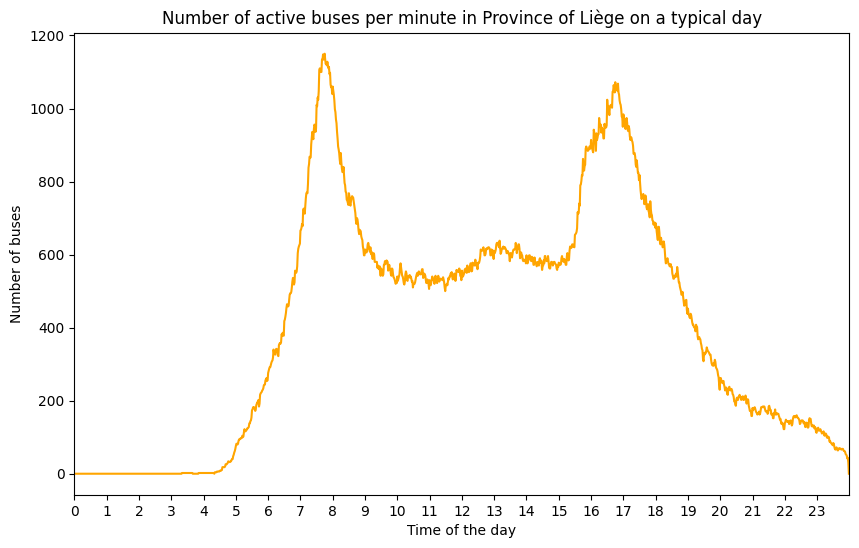

In [102]:
# Iterating over the trajectories to find the median duration of a trip
# and to create a plot of the evolution of the number of active buses over the day

minutes = 24 * 60
nb_busses = np.zeros(minutes)

print(trajs[0].startTimestamp)


median_duration = 0

for traj in trajs:
    median_duration += traj.duration.total_seconds()
    start = traj.startTimestamp
    end = traj.endTimestamp
    start = start.hour * 60 + start.minute
    end = end.hour * 60 + end.minute
    nb_busses[start:end] += 1

median_duration /= len(trajs)*60

print(f"Median duration of a trip: {median_duration} minutes")

plt.figure(figsize=(10, 6))
plt.xlabel('Time of the day')
plt.ylabel('Number of buses')
plt.xlim(0, minutes)
plt.xticks(np.arange(0, minutes, 60), np.arange(0, 24, 1))
plt.title('Number of active buses per minute in Province of Liège on a typical day')
plt.plot(nb_busses, color='orange', label='Number of buses')
plt.savefig('figs/number_of_buses.png')
plt.show()